# Test adding dac

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
from  histlib.diagnosis import global_ms_drifter_sat_year, compute_sum_ms, nMSRe_id, C_x, true_err_x, plot_true_err_cor_part, plot_cor_uncor_part
from histlib.cstes import labels, zarr_dir, matchup_dir, var, c0, c1
from histlib.matchup import _data_var, _stress_var, _aviso_var

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [3]:
DL =25*1e3 #meters
DT = 1800.0 #seconds
id_aviso = 'aviso__25__adt__es_cstrio_z15__drifter_x'
id_co = 'co__25__adt_filtered_ocean_tide_internal_tide_dac__es_cstrio_z15__drifter_x'

id_co_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'alti_ggx_adt_filtered_ocean_tide_internal_tide_dac','wind':'es_cstrio_z15_drifter_wd_x'}
id_aviso_dic =  {'acc':'drifter_acc_x_25','coriolis':'drifter_coriolis_x_25','ggrad':'aviso_drifter_ggx_adt','wind':'es_cstrio_z15_drifter_wd_x'}

# Datasets 

In [5]:
dsms = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'ms_{int(DL//1000)}_{DT}_drogued.zarr'))
gps = [l for l in dsms.drifter_sat_year.values if 'gps' in l]
dsmean = xr.open_dataset(os.path.join(zarr_dir+'_ok','global',f'mean_{int(DL//1000)}_{DT}_drogued.zarr'))

ds, mslow, msup = global_ms_drifter_sat_year(dsmean.sel(drifter_sat_year=gps), dsms.sel(drifter_sat_year=gps), alpha=0.01)
mserr = (msup-mslow)/2

<xarray.DataArray 'nb_coloc' ()>
array(146030)


In [8]:
dsms.sel(drifter_sat_year='gps_Sentinel-3_A_2019')

<xarray.Dataset>
Dimensions:                                                                                   (
                                                                                               id_comb: 80)
Coordinates:
    drifter_sat_year                                                                          <U32 ...
  * id_comb                                                                                   (id_comb) <U75 ...
Data variables: (12/425)
    alti_ggx_adt_filtered                                                                     float64 ...
    alti_ggx_adt_filtered_ocean_tide                                                          float64 ...
    alti_ggx_adt_filtered_ocean_tide_internal_tide                                            float64 ...
    alti_ggx_adt_filtered_ocean_tide_internal_tide_dac                                        float64 ...
    aviso_alti_ggx_adt                                                                        float64 ...
    aviso_drifter_ggx_adt                                                                     float64 ...
    ...                                                                                        ...
    sum_co__2__adt_filtered_ocean_tide__es_cstrio_z15__alti_x                                 float64 ...
    sum_co__2__adt_filtered_ocean_tide__es_cstrio_z15__drifter_x                              float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x                   float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x                float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide_dac__es_cstrio_z15__alti_x               float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide_dac__es_cstrio_z15__drifter_x            float64 ...

______________________
# Closure efficiancy : Residuals

In [9]:
print('Along-track')
print('MSRe = ' + f"{ds['sum_'+id_co].values,mserr['sum_'+id_co].values }")
print(f"nMSRe = {nMSRe_id(ds,mserr, id_co)}")
print('AVISO')
print('MSRe = ' + f"{ds['sum_'+id_aviso].values, mserr['sum_'+id_aviso].values}")
print(f"nMSRe = {nMSRe_id(ds,mserr, id_aviso)}")

Along-track
MSRe = (array(1.59144751e-10), array(1.51706703e-12))
nMSRe = (array(19.69929998), array(0.37557203))
AVISO
ReMS = (array(1.27580759e-10), array(1.2161794e-12))
nMSRe = (array(18.95469763), array(0.36137601))


Text(0, 0.5, 'MSRE $[m^2/s^4]$')

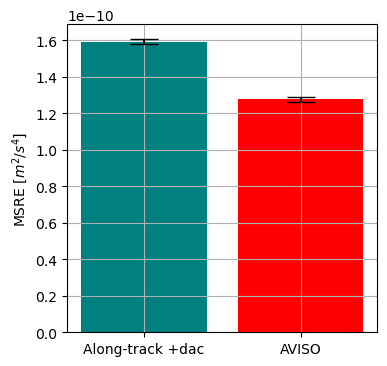

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

ax.bar(0.5, ds['sum_'+id_co], yerr =mserr['sum_'+id_co],  color ='teal',width = 0.4, capsize=10)
ax.bar(1, ds['sum_'+id_aviso], yerr =mserr['sum_'+id_aviso], color ='red',width = 0.4, capsize=10)

ax.grid()

ticks = ('Along-track +dac', 'AVISO')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'MSRE $[m^2/s^4]$')

Text(0, 0.5, '$nMSRe$ [%]')

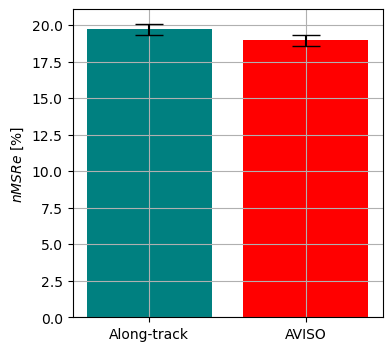

In [12]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

ax.bar(0.5, nMSRe_id(ds,mserr, id_co)[0],yerr = nMSRe_id(ds,mserr, id_co)[1], color ='teal',width = 0.4, capsize=10)
ax.bar(1, nMSRe_id(ds,mserr, id_aviso)[0], yerr = nMSRe_id(ds, mserr,id_aviso)[1], color ='red',width = 0.4, capsize=10)

ax.grid()

ticks = ('Along-track', 'AVISO')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'$nMSRe$ [%]')